# Weather Forecasting - Time-Series Model Training

Notebook ini mengimplementasikan time-series forecasting untuk prediksi cuaca dengan fitur lag dan rolling mean untuk meningkatkan akurasi prediksi.

---

## 1. Persiapan Lingkungan dan Pemuatan Pustaka

Import semua library yang diperlukan untuk analisis dan pemodelan.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (mean_squared_error, mean_absolute_error, 
                             r2_score, accuracy_score, f1_score, 
                             classification_report, confusion_matrix)

import joblib
import os

print("✓ Semua pustaka berhasil diimpor")
print(f"Waktu eksekusi: {datetime.now()}")

✓ Semua pustaka berhasil diimpor
Waktu eksekusi: 2025-12-05 12:13:08.633040


## 2. Pengumpulan dan Pemuatan Data

Load dataset historical weather data dan lakukan eksplorasi awal.

In [2]:
# Ganti path ini dengan lokasi file Anda
DATA_PATH = '../data/historical_data_2000_2024.csv'

# Load data
df = pd.read_csv(DATA_PATH)

# Konversi timestamp ke datetime dan sort
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

print(f"\n{'='*60}")
print("INFORMASI DATASET")
print(f"{'='*60}")
print(f"Jumlah baris: {len(df):,}")
print(f"Rentang waktu: {df['timestamp'].min()} hingga {df['timestamp'].max()}")
print(f"Jumlah tahun: {df['year'].nunique()}")
print(f"\nKolom yang tersedia:")
print(df.columns.tolist())
print(f"\nSample data (5 baris pertama):")
print(df.head())
print(f"\nInfo struktur data:")
print(df.info())


INFORMASI DATASET
Jumlah baris: 227,304
Rentang waktu: 2000-01-01 00:00:00 hingga 2025-12-05 23:00:00
Jumlah tahun: 26

Kolom yang tersedia:
['id', 'timestamp', 'hour', 'day', 'month', 'year', 'temp', 'humidity', 'windspeed', 'sealevelpressure', 'rain', 'precipitation', 'apparent_temperature', 'surface_pressure', 'weather_code', 'conditions', 'temp_max_daily', 'temp_min_daily', 'weather_code_daily', 'temp_mean_daily']

Sample data (5 baris pertama):
   id           timestamp  hour  day  month  year  temp  humidity  windspeed  \
0   0 2000-01-01 00:00:00     0    1      1  2000  21.8        98        4.0   
1   1 2000-01-01 01:00:00     1    1      1  2000  21.4        99        4.0   
2   2 2000-01-01 02:00:00     2    1      1  2000  21.4        98        3.2   
3   3 2000-01-01 03:00:00     3    1      1  2000  21.2        99        4.6   
4   4 2000-01-01 04:00:00     4    1      1  2000  21.0        99        3.6   

   sealevelpressure  rain  precipitation  apparent_temperature  

## 3. Analisis Data Eksplorasi (EDA)

Memahami distribusi, korelasi, dan pola dalam data.

In [3]:
print(f"
{'='*60}")
print("ANALISIS DATA EKSPLORASI (EDA)")
print(f"{'='*60}")

# Statistik Deskriptif
print("nStatistik Deskriptif untuk Fitur Numerik:")
print(df[regression_targets].describe())

# Visualisasi Distribusi
print("Visualisasi Distribusi Parameter Cuaca:")
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Distribusi Parameter Cuaca', fontsize=16)
for i, col in enumerate(regression_targets):
    sns.histplot(df[col], kde=True, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(col)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Analisis Korelasi
print("Heatmap Korelasi Antar Variabel:")
correlation_matrix = df[regression_targets].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi')
plt.show()

# Analisis Deret Waktu (Time Series Plot)
print("Plot Garis Deret Waktu (Sampel 1 Tahun Terakhir):")
df_sample = df[df['timestamp'] > df['timestamp'].max() - pd.Timedelta(days=365)]
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
fig.suptitle('Analisis Deret Waktu (1 Tahun Terakhir)', fontsize=16)
for i, col in enumerate(regression_targets):
    axes[i].plot(df_sample['timestamp'], df_sample[col], label=col)
    axes[i].set_ylabel(col)
    axes[i].legend()
    axes[i].grid(True)
plt.xlabel('Tanggal')
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

SyntaxError: unterminated string literal (detected at line 1) (2577689616.py, line 1)

## 4. Pra-Pemrosesan Data dan Feature Engineering

### 4.1 Label Encoding untuk Kolom Kategorikal

In [ ]:
print(f"\n{'='*60}")
print("FEATURE ENGINEERING - TIME SERIES")
print(f"{'='*60}")

# Label Encoding untuk kolom 'conditions'
le = LabelEncoder()
df['conditions_encoded'] = le.fit_transform(df['conditions'])

print(f"\nLabel Encoding untuk 'conditions':")
print(f"Jumlah kategori unik: {len(le.classes_)}")
print(f"Kategori: {le.classes_[:10]}...")  # Tampilkan 10 pertama


FEATURE ENGINEERING - TIME SERIES

Label Encoding untuk 'conditions':
Jumlah kategori unik: 5
Kategori: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast']...


### 4.2 Membuat Fitur Lag dan Rolling Mean

Fitur lag membantu model memahami pola temporal dengan menggunakan nilai historis.

In [ ]:
# Target columns untuk regression
regression_targets = ['temp', 'humidity', 'windspeed', 'sealevelpressure']

print(f"\nMembuat fitur lag dan rolling mean untuk: {regression_targets}")

for col in regression_targets:
    # Lag 1 jam (1 row sebelumnya)
    df[f'{col}_lag_1'] = df[col].shift(1)
    
    # Lag 24 jam (1 hari sebelumnya)
    df[f'{col}_lag_24'] = df[col].shift(24)
    
    # Rolling mean 24 jam
    df[f'{col}_rolling_mean_24'] = df[col].rolling(window=24, min_periods=1).mean()


Membuat fitur lag dan rolling mean untuk: ['temp', 'humidity', 'windspeed', 'sealevelpressure']


### 4.3 Fitur Cyclical untuk Time Components

Menggunakan sine/cosine encoding untuk menangkap sifat cyclical dari waktu.

In [ ]:
# Tambahan: Fitur cyclical untuk time (sine/cosine encoding)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Drop baris dengan NaN akibat lag features
df_clean = df.dropna().reset_index(drop=True)

print(f"\nJumlah baris setelah menghapus NaN: {len(df_clean):,}")
print(f"Baris yang hilang: {len(df) - len(df_clean):,}")

# Tampilkan sample hasil feature engineering
print(f"\nSample data setelah feature engineering (3 baris pertama):")
feature_cols = ['timestamp', 'temp', 'temp_lag_1', 'temp_lag_24', 'temp_rolling_mean_24']
print(df_clean[feature_cols].head(3))


Jumlah baris setelah menghapus NaN: 227,280
Baris yang hilang: 24

Sample data setelah feature engineering (3 baris pertama):
            timestamp  temp  temp_lag_1  temp_lag_24  temp_rolling_mean_24
0 2000-01-02 00:00:00  22.6        23.2         21.8               24.1875
1 2000-01-02 01:00:00  22.3        22.6         21.4               24.2250
2 2000-01-02 02:00:00  22.3        22.3         21.4               24.2625


## 5. Persiapan Data untuk Training

Definisikan fitur dan target, kemudian split data menggunakan time-series split.

In [ ]:
print(f"\n{'='*60}")
print("PERSIAPAN DATA UNTUK TRAINING")
print(f"{'='*60}")

# Definisikan fitur untuk model
base_features = ['year', 'month', 'day', 'hour', 
                 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']

# Tambahkan lag features untuk setiap target
lag_features = []
for col in regression_targets:
    lag_features.extend([
        f'{col}_lag_1',
        f'{col}_lag_24', 
        f'{col}_rolling_mean_24'
    ])

X_features = base_features + lag_features

# Target untuk regression dan classification
y_regression = df_clean[regression_targets]
y_classification = df_clean['conditions_encoded']

X = df_clean[X_features]

print(f"\nJumlah fitur untuk training: {len(X_features)}")
print(f"Fitur yang digunakan:")
for i, feat in enumerate(X_features, 1):
    print(f"  {i}. {feat}")


PERSIAPAN DATA UNTUK TRAINING

Jumlah fitur untuk training: 20
Fitur yang digunakan:
  1. year
  2. month
  3. day
  4. hour
  5. hour_sin
  6. hour_cos
  7. month_sin
  8. month_cos
  9. temp_lag_1
  10. temp_lag_24
  11. temp_rolling_mean_24
  12. humidity_lag_1
  13. humidity_lag_24
  14. humidity_rolling_mean_24
  15. windspeed_lag_1
  16. windspeed_lag_24
  17. windspeed_rolling_mean_24
  18. sealevelpressure_lag_1
  19. sealevelpressure_lag_24
  20. sealevelpressure_rolling_mean_24


In [ ]:
# Time Series Split (80% train, 20% test)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_reg_train, y_reg_test = y_regression[:split_idx], y_regression[split_idx:]
y_clf_train, y_clf_test = y_classification[:split_idx], y_classification[split_idx:]

print(f"\nPembagian data:")
print(f"  Training set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Test set: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"  Training period: {df_clean['timestamp'].iloc[0]} to {df_clean['timestamp'].iloc[split_idx-1]}")
print(f"  Test period: {df_clean['timestamp'].iloc[split_idx]} to {df_clean['timestamp'].iloc[-1]}")


Pembagian data:
  Training set: 181,824 samples (80.0%)
  Test set: 45,456 samples (20.0%)
  Training period: 2000-01-02 00:00:00 to 2020-09-28 23:00:00
  Test period: 2020-09-29 00:00:00 to 2025-12-05 23:00:00


## 6. Komparasi Model Regresi

Melatih dan membandingkan berbagai algoritma regresi untuk prediksi parameter cuaca.

In [ ]:
print(f"\n{'='*60}")
print("KOMPARASI MODEL REGRESI")
print(f"{'='*60}")

# Definisi model regresi
regression_models = {
    'Linear Regression': LinearRegression(),
    'K-Neighbors Regressor': KNeighborsRegressor(n_neighbors=5),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=15),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, 
                                          max_depth=15, n_jobs=-1)
}

# Dictionary untuk menyimpan hasil
regression_results = {}

for model_name, model in regression_models.items():
    print(f"\n[{model_name}] Training...")
    
    # Train
    model.fit(X_train, y_reg_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluasi untuk setiap target
    results = {}
    for i, target in enumerate(regression_targets):
        mse = mean_squared_error(y_reg_test.iloc[:, i], y_pred[:, i])
        mae = mean_absolute_error(y_reg_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        r2 = r2_score(y_reg_test.iloc[:, i], y_pred[:, i])
        
        results[target] = {
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse,
            'R²': r2
        }
    
    # Hitung rata-rata metrik
    avg_r2 = np.mean([results[t]['R²'] for t in regression_targets])
    avg_rmse = np.mean([results[t]['RMSE'] for t in regression_targets])
    
    regression_results[model_name] = {
        'model': model,
        'detailed_metrics': results,
        'avg_R²': avg_r2,
        'avg_RMSE': avg_rmse
    }
    
    print(f"  ✓ Rata-rata R²: {avg_r2:.4f}")
    print(f"  ✓ Rata-rata RMSE: {avg_rmse:.4f}")


KOMPARASI MODEL REGRESI

[Linear Regression] Training...
  ✓ Rata-rata R²: 0.9046
  ✓ Rata-rata RMSE: 1.7427

[K-Neighbors Regressor] Training...
  ✓ Rata-rata R²: 0.7956
  ✓ Rata-rata RMSE: 2.1299

[Decision Tree] Training...
  ✓ Rata-rata R²: 0.8039
  ✓ Rata-rata RMSE: 2.2652

[Random Forest] Training...
  ✓ Rata-rata R²: 0.8829
  ✓ Rata-rata RMSE: 1.7572


In [ ]:
# Tampilkan tabel perbandingan
print(f"\n{'='*60}")
print("TABEL PERBANDINGAN MODEL REGRESI")
print(f"{'='*60}")

comparison_data = []
for model_name, results in regression_results.items():
    comparison_data.append({
        'Model': model_name,
        'Avg R²': f"{results['avg_R²']:.4f}",
        'Avg RMSE': f"{results['avg_RMSE']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Pilih model terbaik (berdasarkan R²)
best_reg_model_name = max(regression_results.keys(), 
                          key=lambda k: regression_results[k]['avg_R²'])
best_reg_model = regression_results[best_reg_model_name]['model']

print(f"\n✓ Model Regresi Terbaik: {best_reg_model_name}")


TABEL PERBANDINGAN MODEL REGRESI
                Model Avg R² Avg RMSE
    Linear Regression 0.9046   1.7427
K-Neighbors Regressor 0.7956   2.1299
        Decision Tree 0.8039   2.2652
        Random Forest 0.8829   1.7572

✓ Model Regresi Terbaik: Linear Regression


## 7. Komparasi Model Klasifikasi

Melatih dan membandingkan berbagai algoritma klasifikasi untuk prediksi kondisi cuaca.

In [ ]:
print(f"\n{'='*60}")
print("KOMPARASI MODEL KLASIFIKASI")
print(f"{'='*60}")

# Definisi model klasifikasi
classification_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=15),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42,
                                           max_depth=15, n_jobs=-1)
}

# Dictionary untuk menyimpan hasil
classification_results = {}

for model_name, model in classification_models.items():
    print(f"\n[{model_name}] Training...")
    
    # Train
    model.fit(X_train, y_clf_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluasi
    accuracy = accuracy_score(y_clf_test, y_pred)
    f1 = f1_score(y_clf_test, y_pred, average='weighted')
    
    classification_results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1
    }
    
    print(f"  ✓ Accuracy: {accuracy:.4f}")
    print(f"  ✓ F1-Score: {f1:.4f}")


KOMPARASI MODEL KLASIFIKASI

[Logistic Regression] Training...
  ✓ Accuracy: 0.4692
  ✓ F1-Score: 0.4269

[Decision Tree] Training...
  ✓ Accuracy: 0.4077
  ✓ F1-Score: 0.4069

[Random Forest] Training...
  ✓ Accuracy: 0.4782
  ✓ F1-Score: 0.4608


In [ ]:
# Tampilkan tabel perbandingan
print(f"\n{'='*60}")
print("TABEL PERBANDINGAN MODEL KLASIFIKASI")
print(f"{'='*60}")

clf_comparison_data = []
for model_name, results in classification_results.items():
    clf_comparison_data.append({
        'Model': model_name,
        'Accuracy': f"{results['accuracy']:.4f}",
        'F1-Score': f"{results['f1_score']:.4f}"
    })

clf_comparison_df = pd.DataFrame(clf_comparison_data)
print(clf_comparison_df.to_string(index=False))

# Pilih model terbaik (berdasarkan F1-Score)
best_clf_model_name = max(classification_results.keys(),
                          key=lambda k: classification_results[k]['f1_score'])
best_clf_model = classification_results[best_clf_model_name]['model']

print(f"\n✓ Model Klasifikasi Terbaik: {best_clf_model_name}")


TABEL PERBANDINGAN MODEL KLASIFIKASI
              Model Accuracy F1-Score
Logistic Regression   0.4692   0.4269
      Decision Tree   0.4077   0.4069
      Random Forest   0.4782   0.4608

✓ Model Klasifikasi Terbaik: Random Forest


## 8. Analisis Hasil dan Kinerja Individual Parameter

Evaluasi performa model terbaik untuk setiap parameter cuaca.

In [ ]:
print(f"\n{'='*60}")
print("KINERJA INDIVIDUAL PARAMETER (MODEL TERBAIK)")
print(f"{'='*60}")

# Prediksi dengan model terbaik
best_reg_pred = best_reg_model.predict(X_test)
best_clf_pred = best_clf_model.predict(X_test)

# Evaluasi per parameter
print(f"\nModel Regresi: {best_reg_model_name}")
print(f"\n{'Parameter':<20} {'MAE':<12} {'RMSE':<12} {'R²':<12}")
print("-" * 56)

param_metrics = []
for i, target in enumerate(regression_targets):
    mae = mean_absolute_error(y_reg_test.iloc[:, i], best_reg_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_reg_test.iloc[:, i], best_reg_pred[:, i]))
    r2 = r2_score(y_reg_test.iloc[:, i], best_reg_pred[:, i])
    
    print(f"{target:<20} {mae:<12.4f} {rmse:<12.4f} {r2:<12.4f}")
    
    param_metrics.append({
        'Parameter': target,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    })


KINERJA INDIVIDUAL PARAMETER (MODEL TERBAIK)

Model Regresi: Linear Regression

Parameter            MAE          RMSE         R²          
--------------------------------------------------------
temp                 0.4583       0.6539       0.9508      
humidity             2.6767       3.7801       0.9442      
windspeed            1.5741       2.1318       0.7737      
sealevelpressure     0.3216       0.4049       0.9498      


In [ ]:
# Confusion Matrix untuk klasifikasi
print(f"\n\nModel Klasifikasi: {best_clf_model_name}")
print(f"Accuracy: {accuracy_score(y_clf_test, best_clf_pred):.4f}")
print(f"\nConfusion Matrix (sample - top 5 classes):")
cm = confusion_matrix(y_clf_test, best_clf_pred)
print(cm[:5, :5])  # Tampilkan 5x5 pertama saja



Model Klasifikasi: Random Forest
Accuracy: 0.4782

Confusion Matrix (sample - top 5 classes):
[[  830  1434  2860   168     0]
 [  577 11419  4272  2410     1]
 [  542  2878  3145   630     0]
 [   32  3626  1419  6312    28]
 [    4   501   116  2220    32]]


## 9. Penyimpanan Model Terbaik

Simpan model terbaik beserta metadata untuk deployment.

In [ ]:
print(f"\n{'='*60}")
print("PENYIMPANAN MODEL")
print(f"{'='*60}")

# Buat direktori models jika belum ada
MODEL_DIR = '../models'
os.makedirs(MODEL_DIR, exist_ok=True)

# Dictionary berisi semua komponen yang dibutuhkan
model_package = {
    'regressor': best_reg_model,
    'classifier': best_clf_model,
    'label_encoder': le,
    'feature_names': X_features,
    'regression_targets': regression_targets,
    'version': '2.0',
    'trained_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_type': {
        'regressor': best_reg_model_name,
        'classifier': best_clf_model_name
    },
    'performance': {
        'regression_avg_r2': regression_results[best_reg_model_name]['avg_R²'],
        'classification_f1': classification_results[best_clf_model_name]['f1_score']
    }
}

# Save model
MODEL_PATH = os.path.join(MODEL_DIR, 'weather_model_v2.pkl')
joblib.dump(model_package, MODEL_PATH)

print(f"✓ Model berhasil disimpan ke: {MODEL_PATH}")
print(f"  - Regressor: {best_reg_model_name}")
print(f"  - Classifier: {best_clf_model_name}")
print(f"  - Ukuran file: {os.path.getsize(MODEL_PATH) / (1024*1024):.2f} MB")


PENYIMPANAN MODEL
✓ Model berhasil disimpan ke: ../models\weather_model_v2.pkl
  - Regressor: Linear Regression
  - Classifier: Random Forest
  - Ukuran file: 190.38 MB


## 10. Visualisasi Perbandingan Aktual vs Prediksi

Membuat plot untuk membandingkan nilai aktual dengan prediksi model.


VISUALISASI HASIL PREDIKSI
✓ Visualisasi disimpan ke: ../visualizations/actual_vs_predicted.png


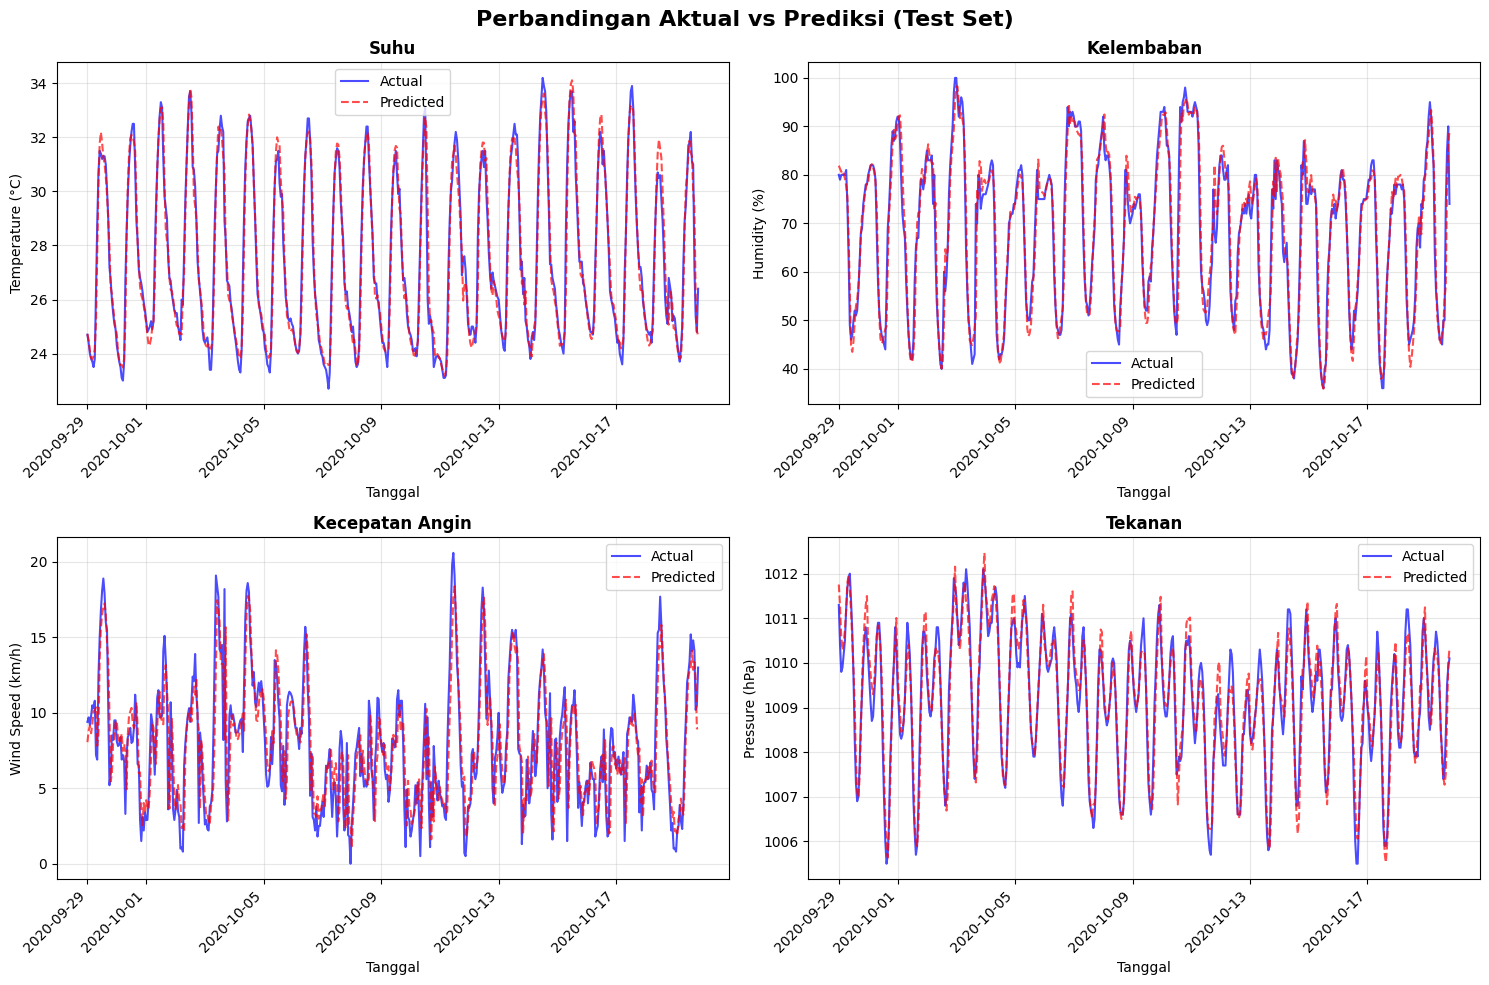

In [ ]:
print(f"\n{'='*60}")
print("VISUALISASI HASIL PREDIKSI")
print(f"{'='*60}")

# Ambil data test period
test_dates = df_clean['timestamp'].iloc[split_idx:].reset_index(drop=True)

# Buat visualisasi untuk setiap parameter
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Perbandingan Aktual vs Prediksi (Test Set)', 
             fontsize=16, fontweight='bold')

targets_labels = {
    'temp': ('Temperature (°C)', 'Suhu'),
    'humidity': ('Humidity (%)', 'Kelembaban'),
    'windspeed': ('Wind Speed (km/h)', 'Kecepatan Angin'),
    'sealevelpressure': ('Pressure (hPa)', 'Tekanan')
}

for idx, target in enumerate(regression_targets):
    ax = axes[idx // 2, idx % 2]
    
    # Ambil 500 data point pertama untuk visualisasi yang lebih jelas
    plot_length = min(500, len(test_dates))
    
    actual = y_reg_test.iloc[:plot_length, idx]
    predicted = best_reg_pred[:plot_length, idx]
    dates_plot = test_dates[:plot_length]
    
    ax.plot(dates_plot, actual, label='Actual', color='blue', linewidth=1.5, alpha=0.7)
    ax.plot(dates_plot, predicted, label='Predicted', color='red', 
            linestyle='--', linewidth=1.5, alpha=0.7)
    
    ax.set_title(targets_labels[target][1], fontsize=12, fontweight='bold')
    ax.set_xlabel('Tanggal')
    ax.set_ylabel(targets_labels[target][0])
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Rotate x-axis labels
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

plt.tight_layout()

# Buat direktori visualizations jika belum ada
os.makedirs('../visualizations', exist_ok=True)
plt.savefig('../visualizations/actual_vs_predicted.png', dpi=300, bbox_inches='tight')
print("✓ Visualisasi disimpan ke: ../visualizations/actual_vs_predicted.png")
plt.show()

## 11. Visualisasi Dampak Data Inkremental

Analisis bagaimana ukuran data training mempengaruhi performa model.

In [ ]:
print(f"\n{'='*60}")
print("INCREMENTAL LEARNING ANALYSIS")
print(f"{'='*60}")

# Uji dampak jumlah data training terhadap performa
data_fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
r2_scores = []

print("\nMelatih model dengan berbagai ukuran data training...")

for fraction in data_fractions:
    # Ambil subset data training
    subset_size = int(len(X_train) * fraction)
    X_train_subset = X_train[:subset_size]
    y_train_subset = y_reg_train[:subset_size]
    
    # Train model (gunakan Random Forest)
    temp_model = RandomForestRegressor(n_estimators=50, random_state=42, 
                                       max_depth=10, n_jobs=-1)
    temp_model.fit(X_train_subset, y_train_subset)
    
    # Evaluate pada test set yang tetap
    y_pred = temp_model.predict(X_test)
    
    # Hitung rata-rata R² untuk semua target
    avg_r2 = np.mean([r2_score(y_reg_test.iloc[:, i], y_pred[:, i]) 
                      for i in range(len(regression_targets))])
    
    r2_scores.append(avg_r2)
    print(f"  {fraction*100:>3.0f}% data: R² = {avg_r2:.4f}")


INCREMENTAL LEARNING ANALYSIS

Melatih model dengan berbagai ukuran data training...
   10% data: R² = 0.7673
   20% data: R² = 0.7881
   30% data: R² = 0.7985
   40% data: R² = 0.7949
   50% data: R² = 0.7962
   60% data: R² = 0.7880
   70% data: R² = 0.7900
   80% data: R² = 0.7992
   90% data: R² = 0.8143
  100% data: R² = 0.8208



✓ Visualisasi disimpan ke: ../visualizations/incremental_learning.png


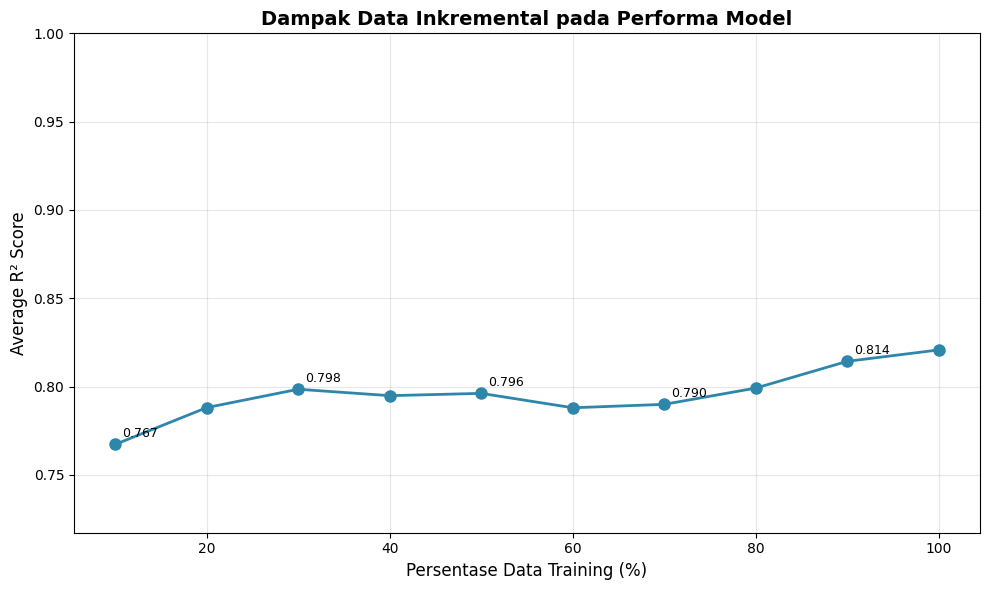

In [ ]:
# Visualisasi
plt.figure(figsize=(10, 6))
plt.plot([f*100 for f in data_fractions], r2_scores, 
         marker='o', linewidth=2, markersize=8, color='#2E86AB')
plt.xlabel('Persentase Data Training (%)', fontsize=12)
plt.ylabel('Average R² Score', fontsize=12)
plt.title('Dampak Data Inkremental pada Performa Model', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.ylim([min(r2_scores) - 0.05, 1.0])

# Tambahkan anotasi
for i, (frac, score) in enumerate(zip(data_fractions, r2_scores)):
    if i % 2 == 0:  # Anotasi setiap 2 point
        plt.annotate(f'{score:.3f}', 
                    xy=(frac*100, score), 
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=9)

plt.tight_layout()
plt.savefig('../visualizations/incremental_learning.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualisasi disimpan ke: ../visualizations/incremental_learning.png")
plt.show()

## 12. Ringkasan Akhir

Tampilkan ringkasan hasil training dan model yang dihasilkan.

In [ ]:
print(f"\n{'='*60}")
print("RINGKASAN TRAINING")
print(f"{'='*60}")
print(f"\n✓ Dataset: {len(df_clean):,} baris data")
print(f"✓ Fitur: {len(X_features)} fitur (termasuk lag & rolling mean)")
print(f"✓ Model Regresi Terbaik: {best_reg_model_name} (R²: {regression_results[best_reg_model_name]['avg_R²']:.4f})")
print(f"✓ Model Klasifikasi Terbaik: {best_clf_model_name} (F1: {classification_results[best_clf_model_name]['f1_score']:.4f})")
print(f"✓ Model tersimpan: {MODEL_PATH}")
print(f"\n{'='*60}")
print("TRAINING SELESAI!")
print(f"{'='*60}\n")


RINGKASAN TRAINING

✓ Dataset: 227,280 baris data
✓ Fitur: 20 fitur (termasuk lag & rolling mean)
✓ Model Regresi Terbaik: Linear Regression (R²: 0.9046)
✓ Model Klasifikasi Terbaik: Random Forest (F1: 0.4608)
✓ Model tersimpan: ../models\weather_model_v2.pkl

TRAINING SELESAI!

